# Reliability Paper Companion

This is basically my attempt at a companion workbook to the current manuscript. That basically means I went through the paper, reproduced the statistics and plots, and then wrote down any discrepancies I found or questions I had.

Like the other notebook, this requires the `processed_data.xlsx` file and nothing else.

# Introduction

There's not really anything to compute in the intro: I have my own setup to do, so that's what I'm doing here.

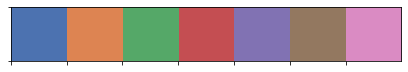

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import statsmodels.api as sm
from IPython.display import display, HTML

USE_DARK = False
palette = cmap = 'deep'
c0, c1, c2, c3, c4, c5, c6 = sns.color_palette(palette, 7)
sns.palplot(sns.color_palette(palette, 7))

rc = {
    'font.family': 'Source Sans Pro',
    'axes.spines.right': False,
    'axes.spines.top': False,
    'figure.figsize': (12, 7),
    'grid.alpha': 0,
}

if USE_DARK:
    COLORS = {
        'fg': '0.8',
        'fg_muted': '0.7',
        'bg': '0.1',
        'bg_muted': '0.2'
    }
    SNS_STYLE='dark'
else:
    COLORS = {
        'fg': '0.1',
        'fg_muted': '0.2',
        'bg': '0.99',
        'bg_muted': '0.95',
    }
    SNS_STYLE='white'

rc.update({
    'text.color': COLORS['fg'],
    'figure.facecolor': COLORS['bg'],
    'axes.facecolor': COLORS['bg'],
    'axes.edgecolor': COLORS['bg_muted'],
    'axes.labelcolor': COLORS['fg_muted'],
    'xtick.color': COLORS['fg'],
    'ytick.color': COLORS['fg'],
    'legend.edgecolor': COLORS['bg_muted'],
})
    
sns.set(context='notebook', style=SNS_STYLE, palette=palette, rc=rc)

In [2]:
sheets = pd.read_excel("processed_data.xlsx", sheet_name=None)
(data, _beliefs_only, beliefs_change, _unmatched_part1, _unmatched_part2, control_means, 
 intervention_means, part1, _part2_ctrl, _part2_intr) = sheets.values()

In [3]:
questions = ['daddy-long-legs', 'women-talk-more', 'wifi-no-cause-cancer', 'illegal-immigrants-crime-less', 'mozart-boosts-iq', 'sugar-hyperactive', 
            'ostriches-hide-head', 'cancer-alternative-medicine', 'caucasian-blue-eyes', 'sleepwalkers-complex-tasks', 'universal-gestures', 
             'taller-in-morning', 'urine-jellyfish-sting', 'opera-shatter-glass', 'carrots-skin-orange', '90%-communication-nonverbal',
            'yawning-contagious', 'goldfish-short-memory', 'use-10%-of-brain', 'dogs-chocolate-bad', 'laughing-improves-vascular', 
            'alcohol-cooks-off', 'testosterone-helps-memory', 'gender-pay-gap', 'glasses-linked-iq', 'cops-dying-more', 'cockroach-headless',
            'gun-murders-highest', 'redheads-dying-out', 'placenta-side-gender', '80%-ocean-unexplored', 'honey-antibacterial',
            'sharks-no-cancer', 'tsunami-caused-earthquake', 'marmite-meat-based', 'elephants-never-forget', 'achoo', 'hypnosis-pain',
            'saunas-sweat-toxins', 'dogs-smell-cancer', 'humans-regrow-tips', 'mercury-vaccines-harmful']
data.rename(columns=lambda x: x.replace('â€œ', '“').replace('â€', '”'), inplace=True)
data.rename(columns=lambda x: x.replace('â€˜', "'").replace('â€™', "'"), inplace=True)
item_wordings = [col.split(' - ')[0] for col in data.columns if col.endswith("to be true?")]
part1_belief = [col for col in data.columns if col.endswith("to be true?")]
familiarity = [col for col in data.columns if col.endswith("this statement before?")]
importance_you = [col for col in data.columns if col.endswith("you whether this is true or false?")]
importance_society = [col for col in data.columns if col.endswith("society whether this is true or false?")]
part2_belief = [col for col in data.columns if col.endswith("to be true? ")]
surprise = [col for col in part1.columns if "surprised" in col]
truth = np.array(["TRUE" in s for s in surprise]).astype(int)

responses = (part1_belief, familiarity, importance_you, importance_society, part2_belief)

In [4]:
type_names = ("Belief 1", "Familiarity", "Importance (You)", "Importance (Society)", "Belief 2")
ID_COL = 'What is your Prolific ID?'

INTERVENTION = 1
CONTROL = 2

def item_number(col):
    try:
        return item_wordings.index(col.split(' - ')[0])
    except ValueError:
        return -1
    
def question_type(col):
    for i, response_type in enumerate(responses):
        if col in response_type:
            return i
    return -1

item_group = data.melt(id_vars=['Condition', ID_COL], var_name='question', value_name='response')
item_group.rename(columns={'Condition': 'condition'}, inplace=True)
item_group['item'] = item_group['question'].apply(item_number)
item_group['type_'] = item_group['question'].apply(question_type)
item_group['cond'] = np.array(["Control", "Intervention"])[2 - item_group['condition']]
item_group = item_group.query('type_ != -1 and item != -1')
item_group.loc[:, 'response'] = pd.to_numeric(item_group['response'])
item_group['type_'] = item_group['type_'].apply(lambda i: type_names[i])
item_group['truth'] = truth[item_group['item']]
intr = item_group.query('condition == @INTERVENTION')
ctrl = item_group.query('condition == @CONTROL')
items = sorted(set(item_group['item']))

In [5]:
intr_b1 = intr.query('type_ == "Belief 1"')
intr_b1.index = range(len(intr_b1.index))
intr_b2 = intr.query('type_ == "Belief 2"')
intr_b2.index = range(len(intr_b2.index))
intr_deltas = intr_b2.copy()
intr_deltas['response'] = intr_deltas['response'] - intr_b1['response']
intr_deltas['2pt_backfire'] = intr_deltas['response'] >= 2
intr_deltas['1pt_backfire'] = intr_deltas['response'] >= 1
myths = np.nonzero(1 - truth)[0]
myth_intr_deltas = intr_deltas.query('item in @myths')

In [6]:
ctrl_b1 = ctrl.query('type_ == "Belief 1"')
ctrl_b1.index = range(len(ctrl_b1.index))
ctrl_b2 = ctrl.query('type_ == "Belief 2"')
ctrl_b2.index = range(len(ctrl_b2.index))
ctrl_deltas = ctrl_b2.copy()
ctrl_deltas['response'] = ctrl_deltas['response'] - ctrl_b1['response']
ctrl_deltas['2pt_backfire'] = ctrl_deltas['response'] >= 2
ctrl_deltas['1pt_backfire'] = ctrl_deltas['response'] >= 1
myth_ctrl_deltas = ctrl_deltas.query('item in @myths')

In [7]:
item_group.to_pickle("exp2-data.pkl")

# Methods

With most of the data manipulation out of the way, onto the methods.

One thing: did I ever get the pilot data?


## Design
Nothing to talk about here.

## Participants

Here I compute all of the demographic statistics that the paper uses.


I get a different retention value than the paper? The manuscript has 526 / 600: I don't know if that was put in before we got more people matched or not.

In [8]:
part2_ids = pd.merge(_part2_ctrl, _part2_intr, how="outer")[ID_COL]
part1_in_2 = part1[part1[ID_COL].isin(part2_ids)]
print("Retention: {} / {} ({:.0%})".format(len(part1_in_2.index), len(part1.index),
                                          len(part1_in_2.index) / len(part1.index)))

Retention: 532 / 600 (89%)


This matches up exactly, so I'm going with there's an error in the retention values.

In [9]:
pd.crosstab(part1_in_2["Are you male or female?"], part1_in_2["Condition"], margins=True)

Condition,1,2,All
Are you male or female?,,,
Female,118,140,258
Male,142,120,262
Prefer not to say / other,8,4,12
All,268,264,532


There were three bad age values that were removed to show the range of ages: I show the indices and values below. Everything matches otherwise. Fun fact: Python libraries seem to pick sample vs. population standard deviation pretty inconsistently!

In [10]:
raw_ages = part1_in_2['What is your age?']

# a problematic age that is being omitted
print(raw_ages[raw_ages == "R5"])
# someone put 282, I doubt that so it's being removed
print(raw_ages[raw_ages == 282])
# someone put 4, also doubt that so it's being removed
print(raw_ages[raw_ages == 4])
ages = pd.to_numeric(raw_ages.drop([69, 162, 437]))
print('-' * 30)
print("Ages range between {} and {} (M = {:.2f}, SD = {:.2f})".format(
    ages.min(), ages.max(), ages.mean(), ages.std(ddof=0)))

437    R5
Name: What is your age?, dtype: object
69    282
Name: What is your age?, dtype: object
162    4
Name: What is your age?, dtype: object
------------------------------
Ages range between 18 and 74 (M = 31.35, SD = 11.08)


## Stimuli/Procedure

Nothing to comment on.

## Analysis Plan
### Control Vs. Intervention Differences

There's one thing I want to mention about the comparison of the post-intervention and pretest control groups: the pre-intervention groups are actually significantly different by condition. I hypothesize that being told that some of the things you're being asked to rate are demonstrably untrue makes people warier.

I'll show that with a distributional test and a test that just compares the orderings. The second graph is signed, which seems to corroborate my theory that the previous question weights heavily on people. This reminds me a lot of asking people to simulate a random sequence in their head: people are overly scared of runs in random sequences.

(Is this a big issue? Probably not, but it's perhaps worth thinking about.)

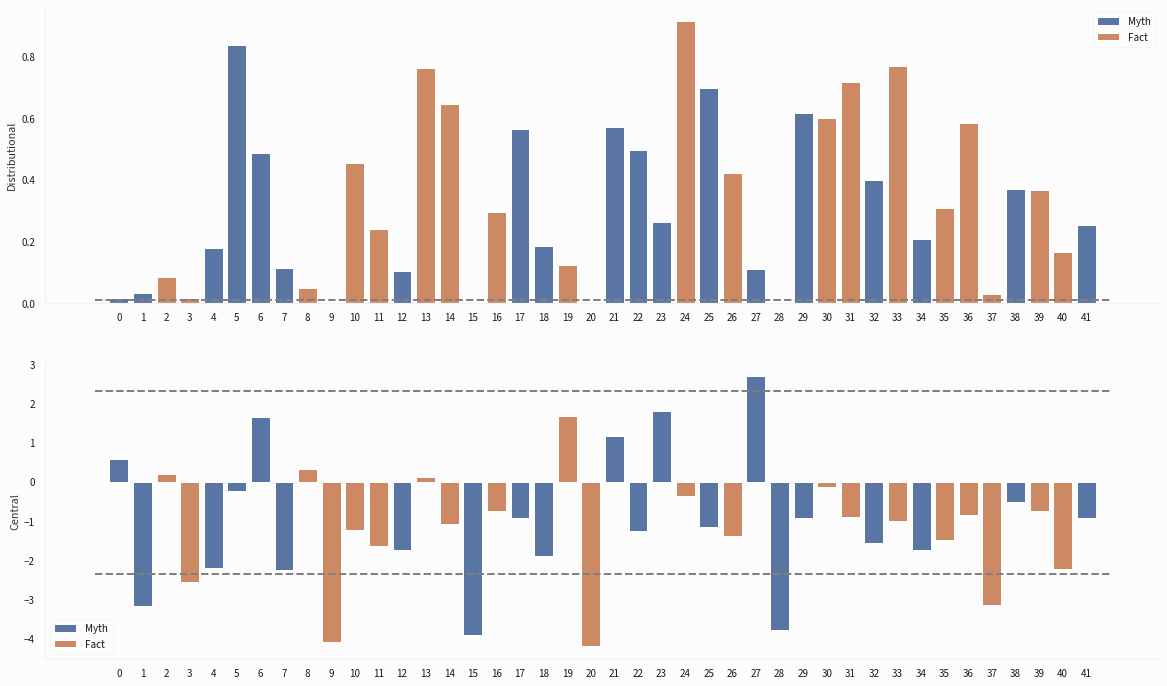

In [11]:
def dist_stat(item_num):
    return scipy.stats.epps_singleton_2samp(
        ctrl_b1.query('item == @item_num')['response'],
        intr_b1.query('item == @item_num')['response']).pvalue

def u_score(item_num):
    return scipy.stats.ttest_ind(
        ctrl_b1.query('item == @item_num')['response'],
        intr_b1.query('item == @item_num')['response']).statistic

dist_stats = pd.Series([dist_stat(i) for i in range(len(questions))], 
                       range(len(questions)), name='Distributional')

u_scores = pd.Series([u_score(i) for i in range(len(questions))], 
                     range(len(questions)), name='Central')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))
sns.barplot(x=list(range(len(questions))), y=dist_stats, 
            hue=np.array(["Myth", "Fact"])[truth.astype(int)],
            dodge=False, ax=ax1)

sns.barplot(x=list(range(len(questions))), y=u_scores, 
            hue=np.array(["Myth", "Fact"])[truth.astype(int)],
            dodge=False, ax=ax2)

n1 = len(ctrl_b1.query('item == 1').index)
n2 = len(intr_b1.query('item == 1').index)

alpha = 0.01
dist_thresh = alpha
ax1.plot([-1, 42], [dist_thresh, dist_thresh], '--', color="grey", lw=2)

u_thresh = scipy.stats.t(df=n1+n2-2).ppf(1 - alpha)
ax2.plot([-1, 42], [u_thresh, u_thresh], '--', color="grey", lw=2)
ax2.plot([-1, 42], [-u_thresh, -u_thresh], '--', color="grey", lw=2)

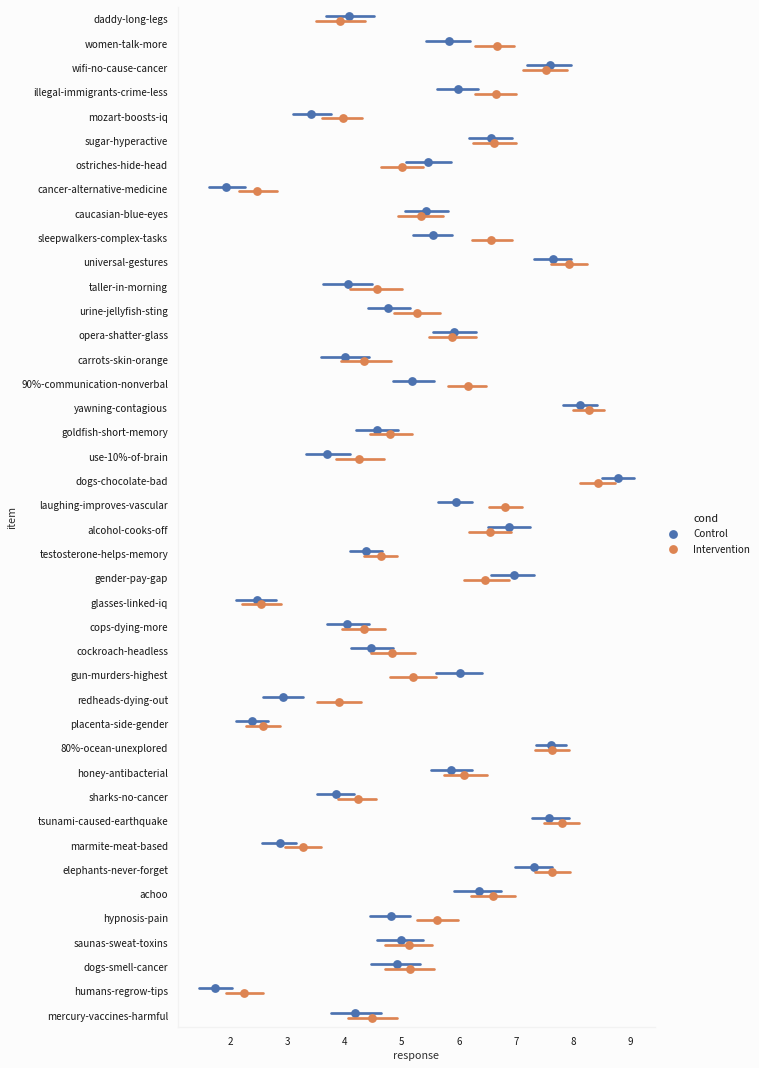

In [12]:
g = sns.catplot(data=item_group.query('type_ == "Belief 1"'), y='item', x='response', 
                hue='cond', kind='point', height=15, aspect=0.5, orient='h',
                dodge=0.2, join=False)

g.set_yticklabels(questions)

### Showing Regression to the Mean With Mean Differences

I agree with your comment that you might give a brief justification for how using all-or-none shifts instead of numerical difference would help prevent regression effects. Perhaps the best way to do that is comparing the different scores against baseline value in some fashion like this?

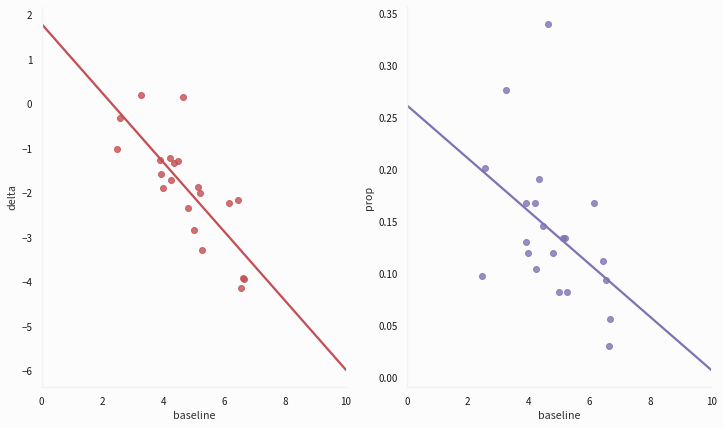

In [13]:
item_df = pd.DataFrame(index=pd.Index(myths, name='item'), data={
    "baseline": intr_b1.query('item in @myths').groupby("item").mean()["response"],
    "delta": myth_intr_deltas.groupby("item").mean()["response"],
    "prop": myth_intr_deltas.groupby("item").mean()["2pt_backfire"]})

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_xlim([0, 10])
sns.regplot(data=item_df, x='baseline', y='delta', ax=ax1, color=c3,
           truncate=False, ci=None)
ax2.set_xlim([0, 10])
sns.regplot(data=item_df, x='baseline', y='prop', ax=ax2, color=c4,
           truncate=False, ci=None)

I have no idea what statistic would be most convincing to indicate this.

### Reliability Calculation
The values I get for some of the future reliability statistics differ from the manuscript: maybe I'm confusing groups?

# Results
## Participants
Here I'll replicate the condition correlations. Joe suggested a demographics table might be a good task for your RA...

I'll be frank that I have no idea how to code partisanship or education or what's standard in the literature. I tried my best...

Also very odd with the Spearman vs. Pearson difference for age: I guess those normality assumptions really do matter after all!


In [14]:
GENDER_CODING = {'Male': 0, 'Female': 1}
genders = part1_in_2["Are you male or female?"]
# sorry nonbinary/private people... I think you're not good for stats
genders = genders[genders.isin(["Male", "Female"])].apply(lambda x: GENDER_CODING[x])

ED_CODING = {
    '2-year college degree': 4,
    '4-year college degree': 5,
    'Did not graduate from high school': 1,
    'High school graduate': 2,
    'Postgraduate degree (MA, MBA, MD, JD, PhD, etc.)': 6,
    'Some college, but no degree': 3
}
ed_levels = part1_in_2["What is the highest level of education you have completed?"]
ed_levels = ed_levels.apply(lambda x: ED_CODING[x])

PARTY_CODING = {'Democrat': 0, 'Republican': 1}
parties = part1_in_2["Generally speaking, do you consider yourself to be a..."]
parties = parties[parties.isin(["Democrat", "Republican"])].apply(lambda x: PARTY_CODING[x])
demos = {
    'Age': (ages, ages),
    'Gender': (genders, part1_in_2["Are you male or female?"]),
    'Education': (ed_levels, part1_in_2["What is the highest level of education you have completed?"]),
    'Partisanship': (parties, part1_in_2["Generally speaking, do you consider yourself to be a..."])
}

columns = ["M", "SD", "p (Pearson)", "p (Spearman)", "p (χ^2)"]
rows = []
for demo, (coded, uncoded) in demos.items():
    row = []
    row.append(data.mean())
    row.append(data.std(ddof=0))
    coded_cond = part1_in_2.loc[coded.index, "Condition"]
    uncoded_cond = part1_in_2.loc[uncoded.index, "Condition"]
    row.append(scipy.stats.pearsonr(coded, coded_cond)[1])
    row.append(scipy.stats.spearmanr(coded, coded_cond)[1])
    row.append(scipy.stats.chi2_contingency(pd.crosstab(uncoded, uncoded_cond))[1])
    rows.append(row)
    
demo_table = pd.DataFrame(index=demos.keys(), columns=columns, data=rows)
demo_table.round(3)

,M,SD,p (Pearson),p (Spearman),p (χ^2)
Age,Participant number ...,Participant number ...,0.516,0.998,0.271
Gender,Participant number ...,Participant number ...,0.054,0.054,0.081
Education,Participant number ...,Participant number ...,0.375,0.412,0.152
Partisanship,Participant number ...,Participant number ...,0.244,0.244,0.531


## Backfire Effects
Perhaps a bit more interesting!

### Item-level Scatterplots

Joe suggested doing both groups with these, so I made two plots for the second experiment (other 2 coming when I get that other data). The version with both myths and facts is very visually pleasing: perfect separation! This also provides a nice illustration of the illusory truth effect "stacking the deck" in favor of backfires.

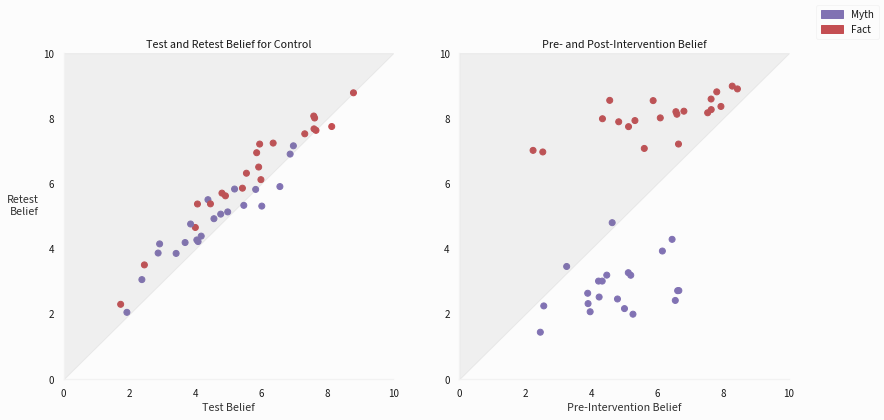

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
colors = [c3 if t else c4 for t in truth]
ax1.scatter(
    ctrl_b1.groupby("item").mean()["response"],
    ctrl_b2.groupby("item").mean()["response"],
    c=colors,
)

ax1.set_title("Test and Retest Belief for Control")
ax1.set_xlabel("Test Belief")
ax1.set_ylabel("Retest\nBelief", ha='right', rotation='horizontal')
ax1.set_xlim([0, 10])
ax1.set_ylim([0, 10])
ax1.fill_between([0, 10], [0, 10], [10, 10], alpha=0.1, color='grey')


ax2.scatter(
    intr_b1.groupby("item").mean()["response"],
    intr_b2.groupby("item").mean()["response"],
    c=colors,
)

ax2.set_title("Pre- and Post-Intervention Belief")
ax2.set_xlabel("Pre-Intervention Belief")
#ax2.set_ylabel("Post-Intervention\nBelief", ha='right', rotation='horizontal')
ax2.set_xlim([0, 10])
ax2.set_ylim([0, 10])
ax2.fill_between([0, 10], [0, 10], [10, 10], alpha=0.1, color='grey')


fig.legend(
    (plt.Circle((0, 0), color=c4), plt.Circle((0, 0), color=c3)),
    ("Myth", "Fact")
)

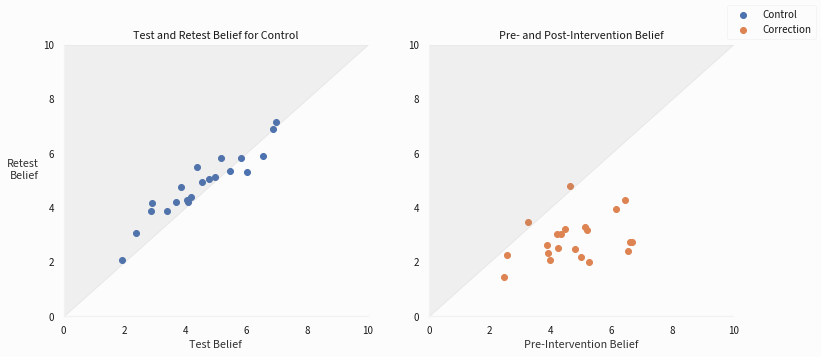

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.scatter(
    ctrl_b1.query('item in @myths').groupby("item").mean()["response"],
    ctrl_b2.query('item in @myths').groupby("item").mean()["response"],
    c=[c0],
    label='Control'
)

ax1.set_title("Test and Retest Belief for Control")
ax1.set_xlabel("Test Belief")
ax1.set_ylabel("Retest\nBelief", ha='right', rotation='horizontal')
ax1.set_xlim([0, 10])
ax1.set_ylim([0, 10])
ax1.fill_between([0, 10], [0, 10], [10, 10], alpha=0.1, color='grey')


ax2.scatter(
    intr_b1.query('item in @myths').groupby("item").mean()["response"],
    intr_b2.query('item in @myths').groupby("item").mean()["response"],
    c=[c1],
    label='Correction'
)

ax2.set_title("Pre- and Post-Intervention Belief")
ax2.set_xlabel("Pre-Intervention Belief")
#ax2.set_ylabel("Post-Intervention\nBelief", ha='right', rotation='horizontal')
ax2.set_xlim([0, 10])
ax2.set_ylim([0, 10])
ax2.fill_between([0, 10], [0, 10], [10, 10], alpha=0.1, color='grey')

fig.legend()

In [17]:
print("Control backfire: {:5.2%}".format(myth_ctrl_deltas["2pt_backfire"].mean()))
print("Intervention backfire: {:5.2%}".format(myth_intr_deltas["2pt_backfire"].mean()))

Control backfire: 24.82%
Intervention backfire: 14.05%


### ANOVA on backfire % per participant from control to intervention

In [18]:
deltas = pd.merge(item_group.query("type_ == 'Belief 1'"),
                 item_group.query("type_ == 'Belief 2'"),
                 on=[ID_COL, 'item'])[
    [ID_COL, 'item', 'response_x', 'response_y', 'condition_x']]

deltas = deltas.query("item in @myths")
deltas.eval("delta = response_y - response_x", inplace=True)
deltas.eval("backfire = delta >= 2", inplace=True)
deltas.eval("onept_backfire = delta >= 1", inplace=True)
deltas.eval("cond = 2 - condition_x", inplace=True) # maps to 0 = ctrl, 1 = intr
deltas.eval("b = 1", inplace=True)  # intercept

mod = sm.OLS(deltas.groupby(ID_COL)["backfire"].mean() * 100, 
             deltas.groupby(ID_COL)[["cond", "b"]].median())
res = mod.fit()
print("MSE = {:5.2f}".format(res.mse_resid))
print(res.summary())

MSE = 162.17
                            OLS Regression Results                            
Dep. Variable:               backfire   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     95.03
Date:                Wed, 13 Jan 2021   Prob (F-statistic):           9.19e-21
Time:                        19:06:12   Log-Likelihood:                -2107.5
No. Observations:                 532   AIC:                             4219.
Df Residuals:                     530   BIC:                             4227.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cond         -10.7649      1.104     -9

Did you want to use 1pt backfire here?

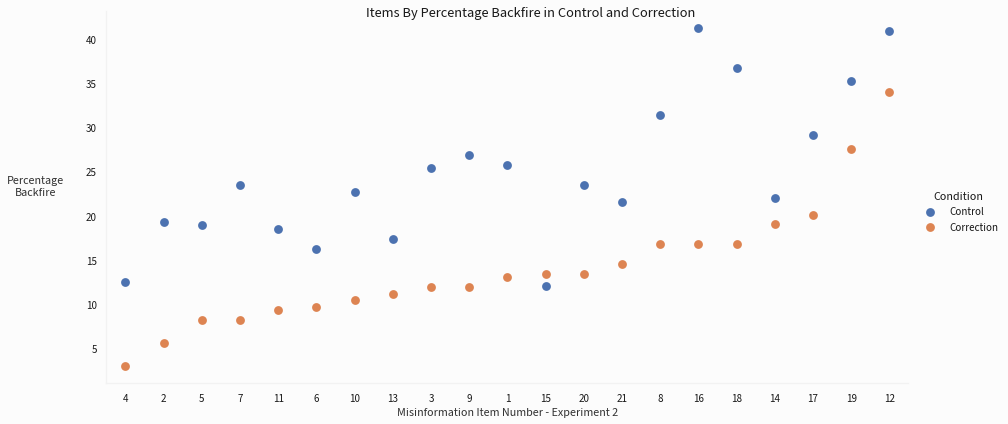

In [19]:
deltas_plot = deltas.eval("backfire = backfire * 100")
deltas_plot["item"]
deltas_plot["Condition"] = np.array(["Control", "Correction"])[deltas_plot["cond"]]
order = myth_intr_deltas.groupby("item").mean()["2pt_backfire"].sort_values().index
g = sns.catplot(data=deltas_plot, x="item", y="backfire", hue="Condition", kind="point", 
                height=6, aspect=2, palette="deep", ci=None, order=order, join=False)

g.fig.suptitle("Items By Percentage Backfire in Control and Correction")
g.ax.set_xticklabels(pd.Series(order).rank().astype(int))
g.ax.set_xlabel("Misinformation Item Number - Experiment 2")
g.ax.set_ylabel("Percentage\nBackfire", labelpad=50, rotation='horizontal');

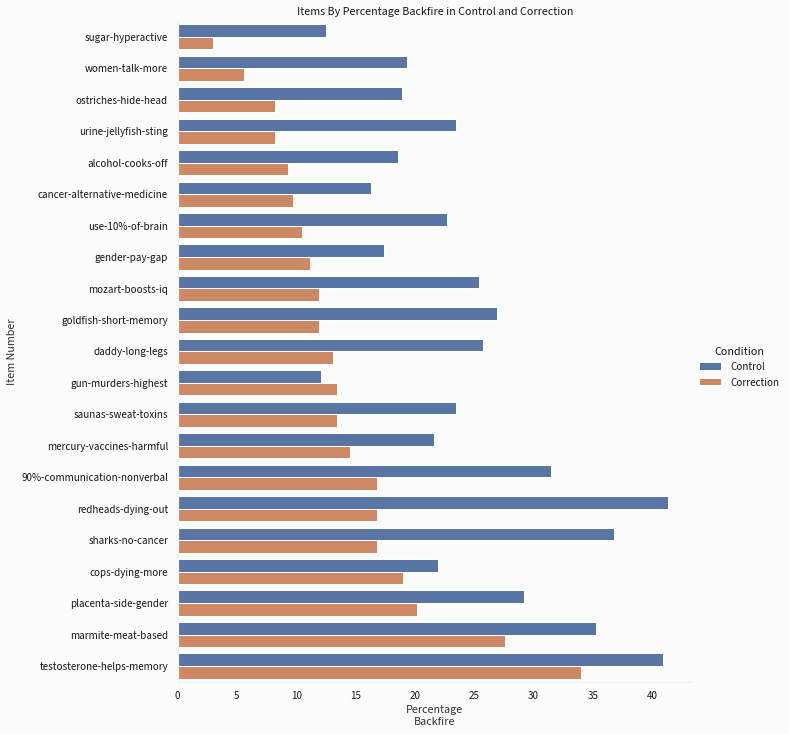

In [20]:
deltas_plot = deltas.eval("backfire = backfire * 100")
deltas_plot["Condition"] = np.array(["Control", "Correction"])[deltas_plot["cond"]]
order = myth_intr_deltas.groupby("item").mean()["2pt_backfire"].sort_values().index
g = sns.catplot(data=deltas_plot, y="item", x="backfire", hue="Condition", kind="bar", 
                height=10, aspect=0.8, palette="deep", orient='h', ci=None, order=order)

g.ax.set_title("Items By Percentage Backfire in Control and Correction")
g.ax.set_ylabel("Item Number")
g.ax.set_yticklabels([questions[i] for i in order])
g.ax.set_xlabel("Percentage\nBackfire");

## Comparison of post-intervention and pre-test group means

In [21]:
def ttest_intr2_ctrl1(item):
    ctrl1 = ctrl_b1.query("item == @item")['response']
    intr2 = intr_b2.query("item == @item")['response']
    return scipy.stats.ttest_ind(intr2, ctrl1)

ttests = pd.DataFrame(index=items, columns=["t", "p"], 
                      data=[ttest_intr2_ctrl1(i) for i in items])

ttests["questions"] = questions

In [22]:
display(ttests.loc[myths, :])

,t,p,questions
0,-6.227243,9.669577e-10,daddy-long-legs
1,-11.632512,5.165410e-28,women-talk-more
4,-5.530863,5.011614e-08,mozart-boosts-iq
5,-14.113247,1.260520e-38,sugar-hyperactive
6,-12.827712,5.387043e-33,ostriches-hide-head
7,-2.236872,2.570977e-02,cancer-alternative-medicine
12,-10.301330,8.321763e-23,urine-jellyfish-sting
15,-4.595273,5.407482e-06,90%-communication-nonverbal
17,-8.168265,2.306130e-15,goldfish-short-memory
18,-4.216746,2.914562e-05,use-10%-of-brain


2.3334042705951576


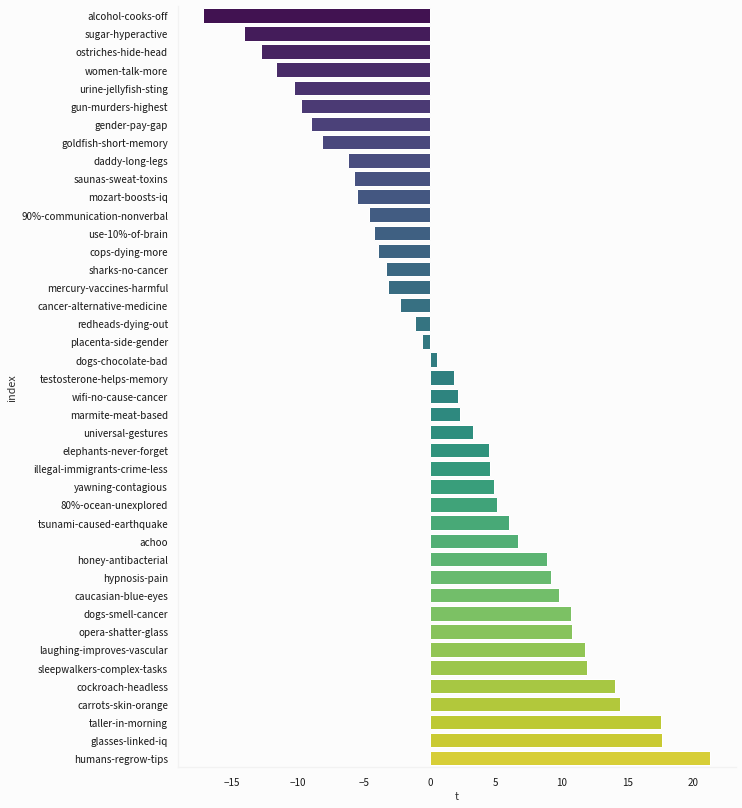

In [23]:
fig, ax = plt.subplots(figsize=(10, 14))
order = ttests.sort_values("t").index
sns.barplot(data=ttests.reset_index(), y="index", x="t", palette='viridis',
           order=order, orient='h', ax=ax)

alpha = 0.01
n1 = len(ctrl_b1.query('item == 0'))
n2 = len(intr_b2.query('item == 0'))
test_stat = scipy.stats.t(n1 + n2 - 2).ppf(1 - alpha)
print(test_stat)

ax.set_yticklabels(np.array(questions)[order]);

# Reliability vs. Backfire

In [24]:
# I'll be doing a lot of item-level regression plots, so I'm streamlining them here
def item_regplot(x, xlabel, y, ylabel, use_spearman=True, **kwargs):
    ax = sns.regplot(x, y, line_kws={'linestyle': ':'}, **kwargs)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel, rotation="horizontal", labelpad=30)
    ylabel_title = ylabel.replace('\n', ' ')
    ax.set_title(f"{xlabel} vs. {ylabel_title}")
    m, b, r, p, std_err = scipy.stats.linregress(x, y)
    if use_spearman:
        r, p = scipy.stats.spearmanr(x, y)
    print("m = {:.3f}, b = {:.3f}, r = {:.3f}, r^2 = {:.3f}, p = {:.3f}, std_err = {:.3f}".format(
        m, b, r, r ** 2, p, std_err))
    return ax

In [25]:
ctrl_items = ctrl.pivot_table(index=["item", ID_COL], columns="type_", values="response")
exp1_ctrl_items = pd.read_json('exp1-ctrl-items.json')
idx = map(eval, exp1_ctrl_items.index)
exp1_ctrl_items.set_index(
    pd.MultiIndex.from_tuples(
        names=['item', ID_COL],
        tuples=[(questions.index(q), id_) for q, id_ in idx]),
    inplace=True)

both_ctrl_items = pd.concat((ctrl_items, exp1_ctrl_items))
reliability = both_ctrl_items.groupby("item").corr('spearman').reset_index(-1).query(
    "type_ == 'Belief 1'")["Belief 2"]
r2 = combo_r2 = reliability ** 2

exp2_reliability = ctrl_items.groupby("item").corr('spearman').reset_index(-1).query(
    "type_ == 'Belief 1'")["Belief 2"]

intr_items = intr.pivot_table(index=["item", ID_COL], columns="type_", values="response")

all_items = item_group.pivot_table(index=["item", ID_COL], columns="type_", values="response")
fam = all_items.groupby("item").mean()["Familiarity"]
imp_soc = all_items.groupby("item").mean()["Importance (Society)"]
imp_you = all_items.groupby("item").mean()["Importance (You)"]
baseline = intr_items.groupby("item").mean()["Belief 1"]

backfire_pct = myth_intr_deltas.groupby("item").mean()["2pt_backfire"] * 100

m = -55.492, b = 48.083, r = -0.725, r^2 = 0.526, p = 0.000, std_err = 8.129


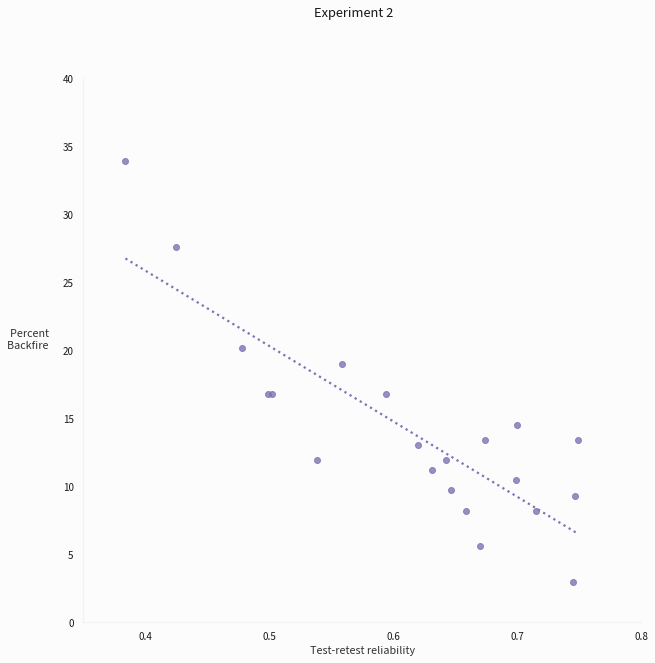

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([0.35, 0.8])
ax.set_ylim([0, 40])
item_regplot(reliability[order[order.isin(myths)]], "Test-retest reliability", 
             backfire_pct.reindex(order[order.isin(myths)]), "Percent   \nBackfire    ", 
             truncate=True, ci=None, ax=ax, color=c4, use_spearman=True)
fig.suptitle("Experiment 2");
ax.set_title('');

m = -50.516, b = 44.538, r = -0.677, r^2 = 0.458, p = 0.001, std_err = 8.531


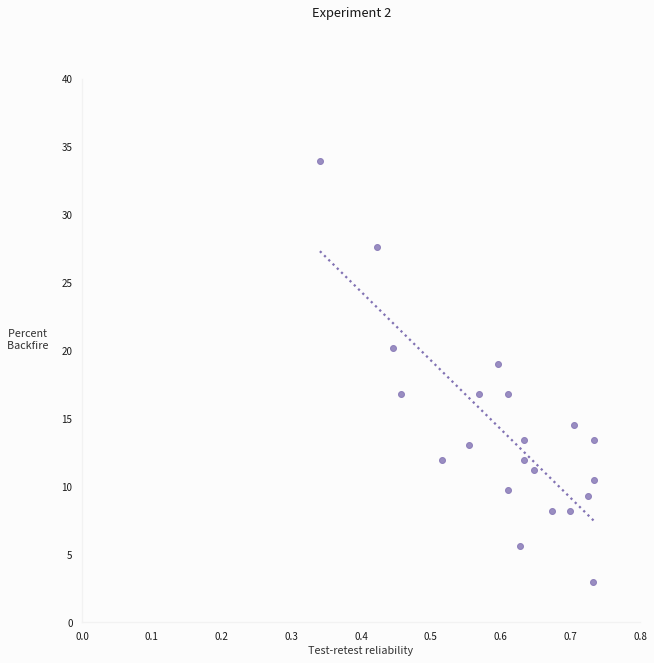

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([0, 0.8])
ax.set_ylim([0, 40])
item_regplot(exp2_reliability[order[order.isin(myths)]], "Test-retest reliability", 
             backfire_pct.reindex(order[order.isin(myths)]), "Percent   \nBackfire   ", 
             truncate=True, ci=None, ax=ax, color=c4, use_spearman=True)
fig.suptitle("Experiment 2");
ax.set_title('');

What are the outliers in familiarity-reliability?

In [28]:
m, b, r, p, se = scipy.stats.linregress(fam, combo_r2)
resids = []
for x, y in zip(fam, combo_r2):
    yhat = m * x + b
    resid = yhat - y
    resids.append(resid)
    
df = pd.DataFrame(index=np.arange(len(questions)), data={'question': questions, 'resid': resids})
df.sort_values('resid', inplace=True)

In [30]:
from bokeh.plotting import figure, output_notebook, show
import bokeh
p = figure(title = "Familiarity vs. Reliability", toolbar_location=None, tools='hover')
p.xaxis.axis_label = 'Familiarity'
p.yaxis.axis_label = 'Reliability'

source = bokeh.models.ColumnDataSource(
    data=dict(fam=fam, r2=r2, resid=df.resid[np.arange(len(df.index))], name=questions))
cm = bokeh.transform.LinearColorMapper(
    palette=bokeh.palettes.Viridis256,
    low=df.resid.min(),
    high=df.resid.max()
)
p.circle('fam', 'r2', source=source, fill_color=bokeh.transform.transform('resid', cm),
         fill_alpha=0.8, size=10)

xx = np.linspace(0, 11, 100)
yy = m * xx + b
p.line(xx, yy)

color_bar = bokeh.models.ColorBar(color_mapper=cm, location=(0, 0),
                     ticker=bokeh.models.BasicTicker(desired_num_ticks=5))
                    #formatter=bokeh.models.PrintfTickFormatter(format="%.2f%%"))

p.hover.tooltips = [
    ("Question", "@name")
]

p.add_layout(color_bar, 'right')

output_notebook()

show(p)

Loading BokehJS ...

### Other Correlations

Everything checks out. I haven't done the Bonferroni correction, but that's not super important here I don't think.

m = nan, b = nan, r = nan, r^2 = nan, p = nan, std_err = nan


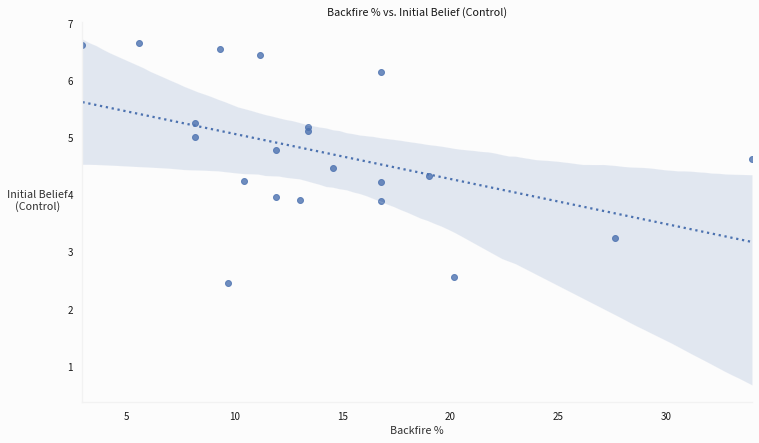

In [31]:
item_regplot(backfire_pct.reindex(order), 'Backfire %', baseline[order], 'Initial Belief\n(Control)')

In [32]:
corr_df = pd.DataFrame({
    'Backfire': backfire_pct / 100,
    '$R^2$': r2,
    'Familiarity': fam,
    'Worldview (Society)': imp_soc,
    'Worldview (Personal)': imp_you
}, index=order)
print("r values:")
display(corr_df.corr('spearman').round(2))
print("p values:")
display(corr_df.corr(lambda x, y: scipy.stats.spearmanr(x, y)[1]).round(4))

r values:


,Backfire,$R^2$,Familiarity,Worldview (Society),Worldview (Personal)
Backfire,1.00,-0.73,-0.83,-0.11,-0.19
$R^2$,-0.73,1.00,0.51,0.04,0.11
Familiarity,-0.83,0.51,1.00,0.17,0.26
Worldview (Society),-0.11,0.04,0.17,1.00,0.96
Worldview (Personal),-0.19,0.11,0.26,0.96,1.00


p values:


,Backfire,$R^2$,Familiarity,Worldview (Society),Worldview (Personal)
Backfire,1.0000,0.0002,0.0000,0.6391,0.3996
$R^2$,0.0002,1.0000,0.0006,0.8025,0.5044
Familiarity,0.0000,0.0006,1.0000,0.2900,0.0987
Worldview (Society),0.6391,0.8025,0.2900,1.0000,0.0000
Worldview (Personal),0.3996,0.5044,0.0987,0.0000,1.0000


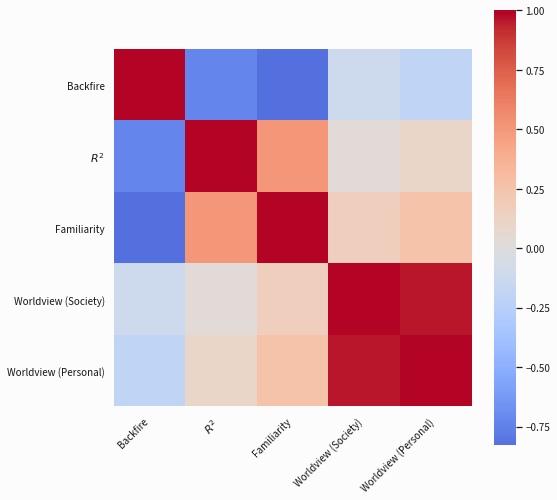

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corr_df.corr('spearman'), cmap='coolwarm', center=0, robust=True, ax=ax,
           square=True);
ax.tick_params(axis='x', labelrotation=45)
ax.tick_params(axis='y', labelrotation=0)
ax.set_xticklabels(ax.get_xticklabels(), ha='right');
ax.set_yticklabels(ax.get_yticklabels(), ha='right');

The last points about backfire rate and belief are interesting: I keep trying to think about how you could tease this out better and it's relatively difficult to do in any way that's statistically valid. It seems like there could be some sort of familiarity -> illusory truth -> beleif increase effect as well as the regression. There are a lot of experiments I want to run!

# Supplements

## Supplement B Table

There are some miniscule differences in p-values. I think this is due to premature rounding: see below.

In [34]:
ctrl_items.loc[5, 'Belief 1']

What is your Prolific ID?
54847013fdf99b0379939c8a    10
54af2a48fdf99b09c01b3801     0
55534b84fdf99b6bd29dd0aa    10
559d9916fdf99b1e2b2dc6b8     9
55a432fcfdf99b02ff6caf92     3
                            ..
5ecc9d9205a2fc4b5fdbaa7b     0
5ecca65afa02b7893b826704     8
5ecd2d655216e6055a573050     8
5ecdd0c2b310f214107639b1     7
5ececb180ce9a12d14704ef5     5
Name: Belief 1, Length: 264, dtype: int64

In [35]:
ctrl_items = ctrl_deltas.groupby('item')
intr_items = intr_deltas.groupby('item')

stat, pval = sm.stats.proportions_ztest(
    [ctrl_items.sum().loc[34, '2pt_backfire'], intr_items.sum().loc[34, '2pt_backfire']],
    [ctrl_items.count().loc[34, '2pt_backfire'], intr_items.count().loc[34, '2pt_backfire']],
    alternative='two-sided')

print("Unrounded Z score: ", stat)
print("Unrounded p value: ", pval)
print("Rounded Z score: 1.89")
print("Rounded p value: ", scipy.stats.norm().cdf(-1.89) * 2)

Unrounded Z score:  1.8923844683762132
Unrounded p value:  0.05843977389550502
Rounded Z score: 1.89
Rounded p value:  0.05875796008081886


In [36]:
b1_3 = np.array(both_ctrl_items.loc[2, 'Belief 1']).reshape(-1)
b2_3 = np.array(both_ctrl_items.loc[2, 'Belief 2']).reshape(-1)
print(b1_3.mean())
print(b2_3.mean())
print(scipy.stats.spearmanr(b1_3, b2_3)[0])

7.36761487964989
7.339168490153173
0.5427501410295902


<ipython-input-36-475b68569686>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  b1_3 = np.array(both_ctrl_items.loc[2, 'Belief 1']).reshape(-1)
<ipython-input-36-475b68569686>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  b2_3 = np.array(both_ctrl_items.loc[2, 'Belief 2']).reshape(-1)


In [37]:
ctrl_items = ctrl_deltas.groupby('item')
intr_items = intr_deltas.groupby('item')

headers = ["Stimulus", "Reliability", "Z ratio between control and correction", 
           "Backfire Rate Threshold 1", "t test pre-test control and post-test correction"]

exp1_table = pd.read_json("exp1-results.json")

rows = []
for (num, item) in enumerate(myths):
    row = []
    row.append("{} {}: {}".format(("Misinformation", "Fact")[
        truth[item]], num + 1, item_wordings[item]))
    # row.append("Z = {:.2f}, p = {:.3f}".format(*sm.stats.proportions_ztest(
    #    [ctrl_items.sum().loc[item, '1pt_backfire'], intr_items.sum().loc[item, '1pt_backfire']],
    #    [ctrl_items.count().loc[item, '1pt_backfire'], intr_items.count().loc[item, '1pt_backfire']],
    #    alternative='two-sided')))
    row.append("{:4.2f}".format(reliability[item]))
    stat, pval = sm.stats.proportions_ztest(
        [ctrl_items.sum().loc[item, '2pt_backfire'], intr_items.sum().loc[item, '2pt_backfire']],
        [ctrl_items.count().loc[item, '2pt_backfire'], intr_items.count().loc[item, '2pt_backfire']],
        alternative='two-sided')
    
    
    
    exp1_stat = exp1_table.loc[num, "Z score test between control and correction"]
    if pval < 0.001:
        row.append("Exp 1: {}\nExp 2: Z = {:.2f}, p < 0.001".format(exp1_stat, stat))
    else:
        row.append("Exp 1: {}\nExp 2: Z = {:.2f}, p = {:.3f}".format(exp1_stat, stat, pval))

    row.append("Exp 1: {}\nExp 2: {:5.2f}".format(
        exp1_table.loc[num, "Exp 1 %Backfire Threshold 1"],
        intr_deltas.groupby('item').mean()['1pt_backfire'][item] * 100))
    # row.append("{:5.2f}".format(intr_items.mean().loc[item, '1pt_backfire'] * 100))
    # row.append("{:5.2f}".format(intr_items.mean().loc[item, '2pt_backfire'] * 100))
    exp1_t = exp1_table.loc[num, "t test"]
    t, t_pval = scipy.stats.ttest_ind(ctrl_b1.query('item == @item')['response'],
                                     intr_b2.query('item == @item')['response'])
    if pval < 0.001:
        row.append("Exp 1: {}\nExp 2: t = {:.2f}, p < 0.001".format(exp1_t, stat))
    else:
        row.append("Exp 1: {}\nExp 2: t = {:.2f}, p = {:.3f}".format(exp1_t, stat, pval))
        
    rows.append(row)
    
supplement_b = pd.DataFrame(columns=headers, index=myths, data=rows)
display(HTML(supplement_b.to_html(index=False, justify='center').replace('\\n', '<br>')))

Stimulus,Reliability,Z ratio between control and correction,Backfire Rate Threshold 1,t test pre-test control and post-test correction
"Misinformation 1: The daddy long legs spider is extremely venomous, but fortunately its fangs are too small to pierce human skin",0.62,"Exp 1: Z = 3.34, p < 0.001Exp 2: Z = 3.71, p < 0.001",Exp 1: 18.46Exp 2: 20.15,"Exp 1: t = 6.15, p < 0.001Exp 2: t = 3.71, p < 0.001"
"Misinformation 2: Females, on average, talk more than males",0.67,"Exp 1: Z = 2.93, p = 0.003Exp 2: Z = 4.80, p < 0.001",Exp 1: 14.36Exp 2: 9.33,"Exp 1: t = 6.91, p < 0.001Exp 2: t = 4.80, p < 0.001"
Misinformation 3: Playing Mozart to your baby will boost its IQ.,0.64,"Exp 1: Z = 2.95, p = 0.003Exp 2: Z = 3.98, p < 0.001",Exp 1: 21.54Exp 2: 19.40,"Exp 1: t = 4.15, p < 0.001Exp 2: t = 3.98, p < 0.001"
Misinformation 4: Sugar makes children hyperactive.,0.74,"Exp 1: Z = 2.90, p = 0.004Exp 2: Z = 4.11, p < 0.001",Exp 1: 8.21Exp 2: 5.97,"Exp 1: t = 8.68, p < 0.001Exp 2: t = 4.11, p < 0.001"
Misinformation 5: Ostriches hide their head in the sand when frightened,0.66,"Exp 1: Z = 4.04, p < 0.001Exp 2: Z = 3.62, p < 0.001",Exp 1: 13.33Exp 2: 15.30,"Exp 1: t = 9.07, p < 0.001Exp 2: t = 3.62, p < 0.001"
"Misinformation 6: Cancer can be cured solely through alternative therapies, without standard cancer treatment",0.65,"Exp 1: Z = 2.85, p = 0.004Exp 2: Z = 2.26, p = 0.024",Exp 1: 14.87Exp 2: 16.79,"Exp 1: t = 1.61, p = 0.107Exp 2: t = 2.26, p = 0.024"
Misinformation 7: Urine is an effective treatment for a jellyfish sting,0.72,"Exp 1: Z = 2.89, p = 0.004Exp 2: Z = 4.83, p < 0.001",Exp 1: 14.36Exp 2: 13.43,"Exp 1: t = 8.64, p < 0.001Exp 2: t = 4.83, p < 0.001"
Misinformation 8: Approximately 90% of communication is nonverbal,0.50,"Exp 1: Z = 3.25, p = 0.001Exp 2: Z = 3.95, p < 0.001",Exp 1: 28.21Exp 2: 22.76,"Exp 1: t = 4.90, p < 0.001Exp 2: t = 3.95, p < 0.001"
Misinformation 9: A goldfish's memory is approximately 7 seconds or less,0.54,"Exp 1: Z = 3.21, p = 0.001Exp 2: Z = 4.36, p < 0.001",Exp 1: 22.05Exp 2: 16.42,"Exp 1: t = 4.48, p < 0.001Exp 2: t = 4.36, p < 0.001"
Misinformation 10: Most people use between 10 and 50% of their brains,0.70,"Exp 1: Z = 2.48, p = 0.013Exp 2: Z = 3.81, p < 0.001",Exp 1: 18.97Exp 2: 16.04,"Exp 1: t = 3.02, p = 0.003Exp 2: t = 3.81, p < 0.001"


In [38]:
rows

[['Misinformation 1: The daddy long legs spider is extremely venomous, but fortunately its fangs are too small to pierce human skin',
  '0.62',
  'Exp 1: Z = 3.34, p < 0.001\nExp 2: Z = 3.71, p < 0.001',
  'Exp 1: 18.46\nExp 2: 20.15',
  'Exp 1: t = 6.15, p < 0.001\nExp 2: t = 3.71, p < 0.001'],
 ['Misinformation 2: Females, on average, talk more than males',
  '0.67',
  'Exp 1: Z = 2.93, p = 0.003\nExp 2: Z = 4.80, p < 0.001',
  'Exp 1: 14.36\nExp 2:  9.33',
  'Exp 1: t = 6.91, p < 0.001\nExp 2: t = 4.80, p < 0.001'],
 ['Misinformation 3: Playing Mozart to your baby will boost its IQ.',
  '0.64',
  'Exp 1: Z = 2.95, p = 0.003\nExp 2: Z = 3.98, p < 0.001',
  'Exp 1: 21.54\nExp 2: 19.40',
  'Exp 1: t = 4.15, p < 0.001\nExp 2: t = 3.98, p < 0.001'],
 ['Misinformation 4: Sugar makes children hyperactive.',
  '0.74',
  'Exp 1: Z = 2.90, p = 0.004\nExp 2: Z = 4.11, p < 0.001',
  'Exp 1: 8.21\nExp 2:  5.97',
  'Exp 1: t = 8.68, p < 0.001\nExp 2: t = 4.11, p < 0.001'],
 ['Misinformation 5: Os